# Project for «Wikishop»

Wikishop online store launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. That is, clients offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation. 

It is necessary to train the model to classify comments into positive and negative. We have at our disposal a data set with markup on the toxicity of edits.

It is necessary to build a model with the value of the quality metric *F1* at least 0.7. 

**Instructions for the implementation of the project**

1. Upload and prepare the data.
2. Train different models. 
3. Draw conclusions.

**Data description**

The data is in the file `toxic_comments.csv`. The *text* column in it contains the comment text, and *toxic* is the target attribute.

In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

## Preparation

### Import

In [2]:
df = pd.read_csv('datasets/toxic_comments.csv')
df = df.sample(90000).reset_index(drop=True).drop(columns=['Unnamed: 0'])
display(df)
df.info()

,text,toxic
0,I hope World of Warcraft dies a long and painf...,1
1,Incorrect. Check the diff again.,0
2,"""Is it just me, or is this sentence a little t...",0
3,"""\n\nDid you forgot the """"New From Disney Inte...",0
4,"""\n\nHuh ? If they are English by descent, """"i...",0
...,...,...
89995,"go fuck yourself, how is this unconstructive y...",1
89996,October 2007 \n Please stop. If you continue t...,0
89997,"I recognize that, and that's why I used browse...",0
89998,Um... okay. Those ARE the rules though. And th...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    90000 non-null  object
 1   toxic   90000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


*BECAUSE WITH THE FULL AMOUNT OF DATA, THE CORE OF JUPITER WAS TURNED OFF, IT WAS DECIDED TO REDUCE THE NUMBER OF SOURCE DATA TO 90 THOUSAND ROWS*

In [3]:
corpus = df['text']
corpus[0]

"I hope World of Warcraft dies a long and painful death\nWorld of Warcraft sucks the biggest donkey balls on this planet. I cannot express how much I hate this piece of wank other than hoping it is raped, stabbed, drowned, raped again when it's dead, drown it in its own blood from being stabbed. Afterwards, it should be buried in a 150 feet deep pit full of maggots and when they have finished with it, the whole pit should be set alight with 20,000 matches."

### Lemmatize, clear out unnecessary words, reduce to a common register

In [4]:
nltk.download('punkt')
nltk.download('wordnet')

corpus = corpus.apply(lambda sentence: re.sub(r'[^a-zA-Z]',' ',sentence))

lemmatizer = WordNetLemmatizer()
lemm_corpus = corpus.apply(lambda sentence: " ".join([lemmatizer.lemmatize(w,"n") for w in nltk.word_tokenize(sentence)]))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egors\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\egors\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df['lemm_text'] = lemm_corpus
df

,text,toxic,lemm_text
0,I hope World of Warcraft dies a long and painf...,1,I hope World of Warcraft dy a long and painful...
1,Incorrect. Check the diff again.,0,Incorrect Check the diff again
2,"""Is it just me, or is this sentence a little t...",0,Is it just me or is this sentence a little too...
3,"""\n\nDid you forgot the """"New From Disney Inte...",0,Did you forgot the New From Disney Interactive...
4,"""\n\nHuh ? If they are English by descent, """"i...",0,Huh If they are English by descent indigenous ...
...,...,...,...
89995,"go fuck yourself, how is this unconstructive y...",1,go fuck yourself how is this unconstructive yo...
89996,October 2007 \n Please stop. If you continue t...,0,October Please stop If you continue to vandali...
89997,"I recognize that, and that's why I used browse...",0,I recognize that and that s why I used browser...
89998,Um... okay. Those ARE the rules though. And th...,1,Um okay Those ARE the rule though And thanks s...


### Class imbalance check

<AxesSubplot:ylabel='Frequency'>

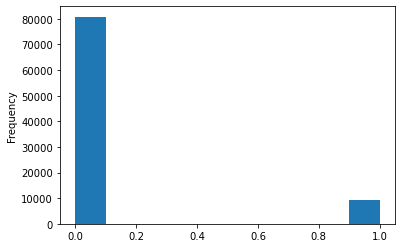

In [6]:
df['toxic'].plot(kind='hist')

Class imbalance detected

### Data separation

In [7]:
features = df['lemm_text']
target = df['toxic']

In [8]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.1, 
                                                                            random_state=12345,
                                                                            stratify=target)

In [9]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(features_train)

tf_idf_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\egors\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Conclusion

- Due to the fact that with the total number of data, the Jupiter core was turned off, it was decided to reduce the number of source information to 80 thousand lines

- The source data has no gaps

- The original data were lemmatized, cleared of unnecessary words, reduced to a common register

- For training, the data was divided into training and test samples, TF-IDF was calculated

## Training

### LogisticRegression

In [10]:
model = LogisticRegression()
model.fit(tf_idf_train,target_train)
predictions = model.predict(tf_idf_test)
print('F1 = ', round(f1_score(target_test,predictions),3))

F1 =  0.698


### Random Forest Classifier

In [11]:
%%time

rfc = RandomForestClassifier(class_weight='balanced', random_state=12345)
params_rfc = {'max_depth':range(4,8), 'n_estimators':range(20, 40, 5)}
rfc_grid = GridSearchCV(rfc, params_rfc, cv=3, scoring='f1')
rfc_grid.fit(tf_idf_train, target_train)
rfc_grid.best_params_

Wall time: 4min 10s


{'max_depth': 6, 'n_estimators': 35}

In [12]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth = rfc_grid.best_params_['max_depth'],
                            n_estimators = rfc_grid.best_params_['n_estimators'])
rfc.fit(tf_idf_train,target_train)
predictions = rfc.predict(tf_idf_test)
print('F1 = ', round(f1_score(target_test,predictions),3))

F1 =  0.327


### LGBMClassifier

In [13]:
%%time
lgbm = LGBMClassifier()

param_grid = {
    'learning_rate': np.arange(0.1,1,0.2),
    'n_estimators': range(20, 100, 10)
}


gbm = GridSearchCV(lgbm, param_grid, scoring='f1',cv=3)
gbm.fit(tf_idf_train, target_train)
gbm.best_params_

Wall time: 29min 6s


{'learning_rate': 0.30000000000000004, 'n_estimators': 90}

In [14]:
lgbm = LGBMClassifier(learning_rate=gbm.best_params_['learning_rate'],
                     n_estimators=gbm.best_params_['n_estimators'])

lgbm.fit(tf_idf_train,target_train)
predictions = lgbm.predict(tf_idf_test)
print('F1 = ', round(f1_score(target_test,predictions),3))

F1 =  0.743


## Conclusion

The best scoring is given by LGBMClassifier model - f1_score = 0.743